In [1]:
import os
import pytorch_lightning as pl
from argparse import ArgumentParser
from uuid import uuid4
import torch as ch
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from os import path

import numpy as np
import torch as ch
import pytorch_lightning as pl
from torch.utils.data import random_split, DataLoader, TensorDataset, Dataset
import scipy.stats as stats



In [2]:
def plot_genes(labels_data0, yhat_data0, cmap, index):
  
    all_d = pd.concat([pd.DataFrame(labels_data0), pd.DataFrame(yhat_data0[:,index])], axis = 1)
    all_d.columns = ['x', 'y','z','feature'+str(index)]

    
    g = sns.scatterplot(data = all_d, x = 'x', y = 'y', hue = 'feature'+str(index),palette= cmap)
    
    return g

def load_data(data_dir, prefix="Cell"):
        #expr = pd.read_csv(os.path.join(data_dir, "data_table.csv"), index_col=0)
    expr = pd.read_csv(os.path.join(data_dir, "cell_barcode_count.csv"), header=None)
    gene_names = pd.read_csv(os.path.join(data_dir, "cell_barcode_names.csv"),header=None)
    rownames = [i for i in range(expr.shape[0])]
    names = gene_names[2]
    names.name = "Gene"
    return pd.DataFrame(data=expr.values, columns=names, index=rownames)



In [8]:
import sys
sys.path.append('/Users/work/Documents/GitHub')

from mlgenomics.djuna_models.MatrixFNN_Djuna import SimpleFNN

In [9]:
# load the model (change the directory to point to your location of mlgenomics)
PATH = '/Users/work/Documents/GitHub/mlgenomics/djuna_models/lightning_logs/version_0_Wang_2018_all_2D_3D_processed_new/checkpoints/epoch=517-v0.ckpt'
new_model_unseen = SimpleFNN.load_from_checkpoint(checkpoint_path=PATH)
new_model_unseen.eval()

"lr": 0.001


SimpleFNN(
  (layers): Sequential(
    (0): Linear(in_features=1030, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Linear(in_features=128, out_features=128, bias=True)
    (7): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Linear(in_features=128, out_features=128, bias=True)
    (10): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): Linear(in_features=128, out_features=128, bias=True)
    (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): Linear(in_features=128, out_features=3, bias=True)
  )
)

In [10]:
# select dataset of interest

direct_leftout = '/Users/work/Documents/GitHub/mlgenomics/data_preprocessing/Wang_2018_all_2D_3D_processed_new.npz'
content_leftout = np.load(direct_leftout)['arr_0']
unseen_0 = content_leftout[content_leftout[:,-1]==0,] # selecting features corresponding to dataset 1

# col 0 to 1029 correspond to features
# col 1030-32 correspond to x,y,z (for 2D data, z = 0)
# col 1033 corresponds to the dataset annotation 
# where the order 0-9 corresponds to the datasets listed in the order below (ie 20180505_BY3_1kgenes = dataset1)
# the 3D dataset is dataset 10
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

# set dirs equal to if not djuna's laptop 

dirs = ['20180505_BY3_1kgenes',
 '20171110_BF2_dark',
 '20180410-BY3_1kgenes',
 '20180421_BZ19_cocaine',
 '20170915_BD2_dark',
 '20171115_BF5_light',
 '20180424_BZ14_control',
 '20171120_BF4_light',
 '20180419_BZ9_control',
 '20180417_BZ5_control']

dirs


['20180505_BY3_1kgenes',
 '20171110_BF2_dark',
 '20180410-BY3_1kgenes',
 '20180421_BZ19_cocaine',
 '20170915_BD2_dark',
 '20171115_BF5_light',
 '20180424_BZ14_control',
 '20171120_BF4_light',
 '20180419_BZ9_control',
 '20180417_BZ5_control']

In [11]:
# get elements of the dataset and store as tensor

data_unseen = ch.from_numpy(unseen_0[:, :-4]).float()
# @Fatima: you can use the code in the previous code chunk to load the data you want to analyze, @Na: you would
# need to replace 'unseen_0' with the single-cell counts

coordinates_unseen = ch.from_numpy(unseen_0[:, -4:-1]).float()
dataindex_unseen = ch.from_numpy(unseen_0[:,-1]).float() 
full_dataset_unseen  = TensorDataset(data_unseen , coordinates_unseen , dataindex_unseen )

In [12]:
# run the model on the dataset 

# (you cann modify the for loop to include only the outputs you need (i.e. teh model predictions, out))

out = []
index = []
label = []
feature = []
for features, labels, dataset_idx in (iter(DataLoader(full_dataset_unseen))):
    label.append(labels.detach().numpy())
    index.append(dataset_idx.detach().numpy())
    feature.append(features.detach().numpy())
    out.append((new_model_unseen(features, dataset_idx)).detach().numpy())


In [13]:
# concatenate the output 

yhat = np.concatenate(out) # yhat corresponds to the model prediction (this is what you'll be interested in)
idx = np.concatenate(index)
label = np.concatenate(label) # corresponds to the actual coordinates
features = np.concatenate(feature) # corresponds to the input features

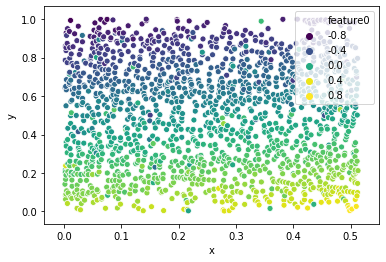

In [14]:
# plot predicted feature 0 on cells plotted in actual measured 2D coordinates
plot_genes(label, yhat, 'viridis', 0)

In [15]:
# get gene annotations: all_genes correspond to the column labels from column 0 to column N (where N = len(all_genes))
# in Wang_2018_all_2D_3D_processed_new

genenames_3D = pd.read_csv('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/sequentially_encoded_Wang_et_al_2018/gene_names.csv', header = 0)

dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')

ct = []
for i in range(len(dirs)):

    data_dir1 = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[i])
    ct.append(load_data(data_dir1, prefix=""))

genenames = []
for i in range(len(dirs)):
    genenames.append(ct[i].columns)
all_genes = np.unique(np.concatenate((np.unique(np.concatenate(genenames)),(np.array(genenames_3D).flatten()))))


In [16]:
# get labels for this dataset
dirs = os.listdir('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets')
data_dir = os.path.join('/Users/work/Documents/GitHub/mlgenomics/data_as_downloaded/combinatorially_encoded/all_datasets',dirs[0],'class_labels.csv')
celltype_labels = pd.read_csv(data_dir)

# subset the coordinates in labels to only include cells for which we have annotations
labels_subsetted = label[np.array(celltype_labels[['CellID']]).flatten(),:]
# N.B. for some datasets, we seem to have fewer celltype labels than cells. From what I can tell, he cellype
# labels correspond to the rows in the feature/label matrix (i.e cells for which we do not have labels are at the end)
# I am not 100% sure of this, but the annotations look right when I plot them 
# I think this is the case because in the load_data function provided by the authors, they annotate the rows
# with cell_ID + rownumber and thus the row indices correspond to the cellIDs, which correspond to the cellIDs in 
# the labels dataframe 

celltype_labels = np.array(celltype_labels[['ClusterName']]).flatten()

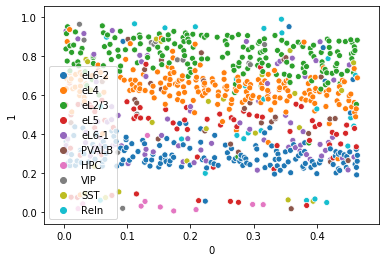

In [17]:
# plot cells to check 
include = set(('Astro-1',
 'Astro-2',
 'Endo',
 'Micro',
 'Oligo',
 'Astro', 'Smc', 'Astro'))

subsetted_labels_neurons = [None if item in include else item for item in celltype_labels]
sns.scatterplot(data = pd.DataFrame(labels_subsetted), x = 0, y = 1, hue =subsetted_labels_neurons)


In [22]:
pd.DataFrame(labels_subsetted).columns


RangeIndex(start=0, stop=3, step=1)